In [33]:
!pip install statsforecast

In [34]:
# prompt: mount drive

from google.colab import drive
drive.mount('/content/drive')

my_path = "/content/drive/MyDrive/EDAF/Intro_data_forecast/fpp3-python/"
# /content/drive/MyDrive/EDAF/Intro_data_forecast/fpp3-python/Assets

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 2 Some simple forecasting methods
***
Some forecasting methods are extremely simple and surprisingly effective. We will use four simple forecasting methods as benchmarks throughout this book. To illustrate them, we will use quarterly Australian clay brick production between 1970 and 2004.

In [35]:
#Import the libraries that we are going to use for the analysis:
import pandas as pd
import numpy as np

from statsforecast import StatsForecast
from statsforecast.models import __all__

import matplotlib.pyplot as plt

In [36]:
# Create a dataframe from a csv file:
df = pd.read_csv(my_path + "Assets/aus-production.csv", sep=";")
bricks = df[["Quarter","Bricks"]]
bricks.columns = ["ds","bricks_prod"]

*To filter DataFrames with Boolean Masks we use the index operator and pass a comparison for a specific column.*


In [37]:
#Inferior limit:
bricks_mask=bricks['ds']>="1970 Q1"
filtered_bricks = bricks[bricks_mask]

#Superior limit:
df_mask=filtered_bricks['ds']<="2004 Q4"
bricks = filtered_bricks[df_mask]

print(bricks)

          ds  bricks_prod
56   1970 Q1        386.0
57   1970 Q2        428.0
58   1970 Q3        434.0
59   1970 Q4        417.0
60   1971 Q1        385.0
..       ...          ...
191  2003 Q4        413.0
192  2004 Q1        409.0
193  2004 Q2        423.0
194  2004 Q3        428.0
195  2004 Q4        397.0

[140 rows x 2 columns]


## Mean method

Here, the forecasts of all future values are equal to the average (or “mean”) of the historical data. If we let the historical data be denoted by $y_{1},...,y_{T}$, then we can write the forecasts as

\begin{gather*}
\hat{y}_{T+h|T}=\bar{y}=(y_{1}+⋯+y_{T})/T
\end{gather*}

The notation $\hat{y}_{T+h|T}$ is a short-hand for the estimate of $y_{T+h}$ based on the data $y_{1},...,y_{T}$





In [38]:
# HistoricAverage's usage example:
from statsforecast.models import HistoricAverage

# Create an array with the observed values in Bricks:
y_bricks = bricks["bricks_prod"].values

# Define the model, fit and predict:
model = HistoricAverage()
model = model.fit(y=y_bricks)
y_hat_dict = model.predict(h=20)

y_hat_dict

{'mean': array([450.87857143, 450.87857143, 450.87857143, 450.87857143,
        450.87857143, 450.87857143, 450.87857143, 450.87857143,
        450.87857143, 450.87857143, 450.87857143, 450.87857143,
        450.87857143, 450.87857143, 450.87857143, 450.87857143,
        450.87857143, 450.87857143, 450.87857143, 450.87857143])}

In [39]:
# Specify the quarters predicted:
qua_pred = ['2005 Q1', '2005 Q2', '2005 Q3', '2005 Q4', '2006 Q1', '2006 Q2', '2006 Q3', '2006 Q4', '2007 Q1', '2007 Q2', '2006 Q1', '2006 Q2', '2006 Q3', '2006 Q4', '2007 Q1', '2007 Q2', '2007 Q3', '2007 Q4', '2008 Q1', '2008 Q2' ]

# Create a dataframe with the quarters and values predicted:
Y_pred_df = pd.DataFrame({'ds':qua_pred ,
                        'mean_forecast':y_hat_dict["mean"]})

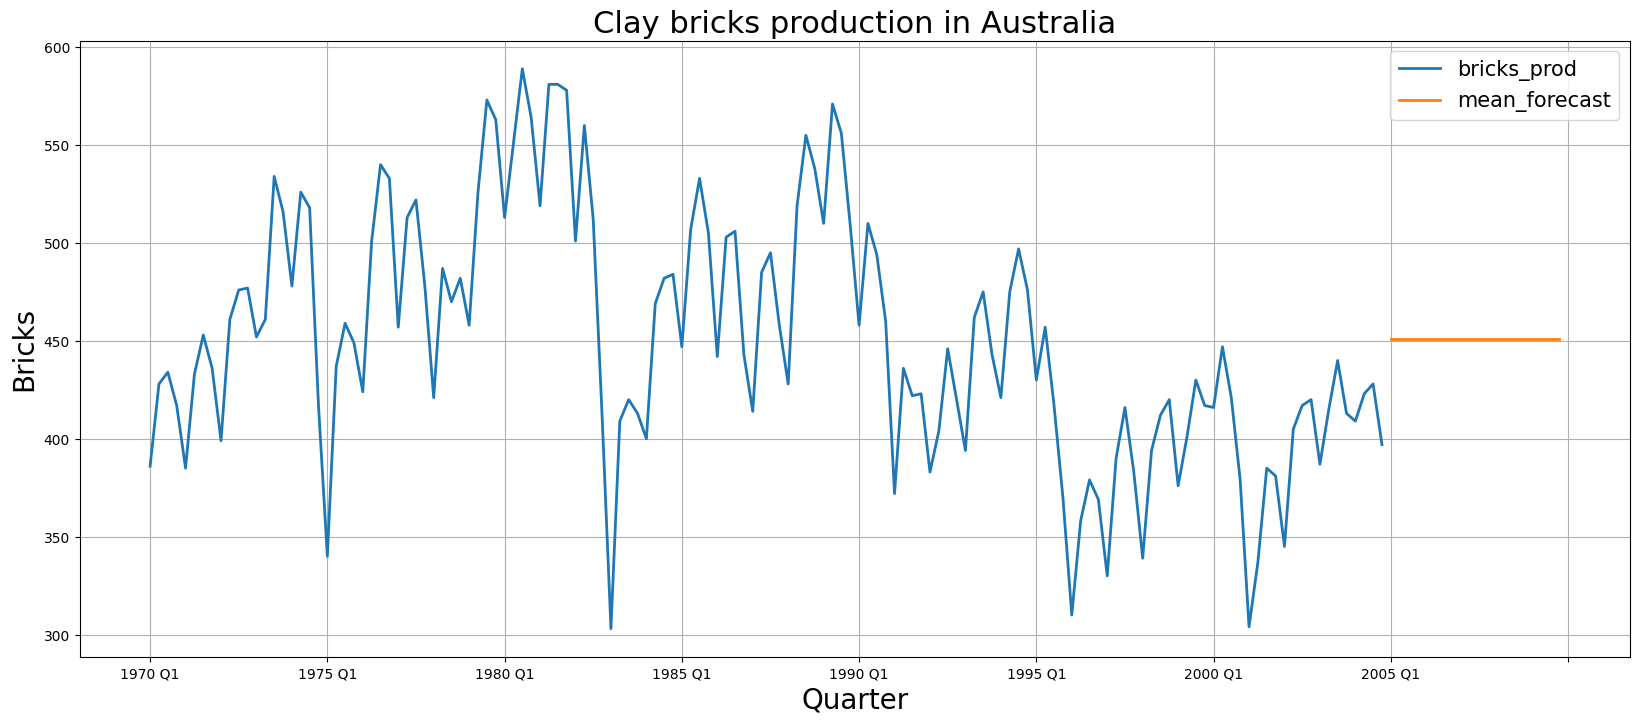

In [40]:
fig, ax = plt.subplots(1, 1, figsize = (20, 8))

# Concatenate the dataframe of predicted values with the dataframe of observed values:
plot_df = pd.concat([bricks, Y_pred_df]).set_index('ds')
plot_df[['bricks_prod', 'mean_forecast']].plot(ax=ax, linewidth=2)

# Specify graph features:
ax.set_title('Clay bricks production in Australia', fontsize=22)
ax.set_ylabel('Bricks', fontsize=20)
ax.set_xlabel('Quarter', fontsize=20)
ax.legend(prop={'size': 15})
ax.grid()

<p style="text-align: center;">
Figure 3: Mean (or average) forecasts applied to clay brick production in Australia.
</p>

## Naïve method

For naïve forecasts, we simply set all forecasts to be the value of the last observation. That is,

\begin{gather*}
\hat{y}_{T+h|T}=y_{T}
\end{gather*}

This method works remarkably well for many economic and financial time series.

In [41]:
# Naive's usage example:
from statsforecast.models import Naive

# Define the model, fit and predict:
model = Naive()
model = model.fit(y=y_bricks)
y_hat_dict = model.predict(h=20)

y_hat_dict

{'mean': array([397., 397., 397., 397., 397., 397., 397., 397., 397., 397., 397.,
        397., 397., 397., 397., 397., 397., 397., 397., 397.])}

In [42]:
# Create a column with the values predicted:
Y_pred_df["naive_forecast"] = y_hat_dict["mean"]

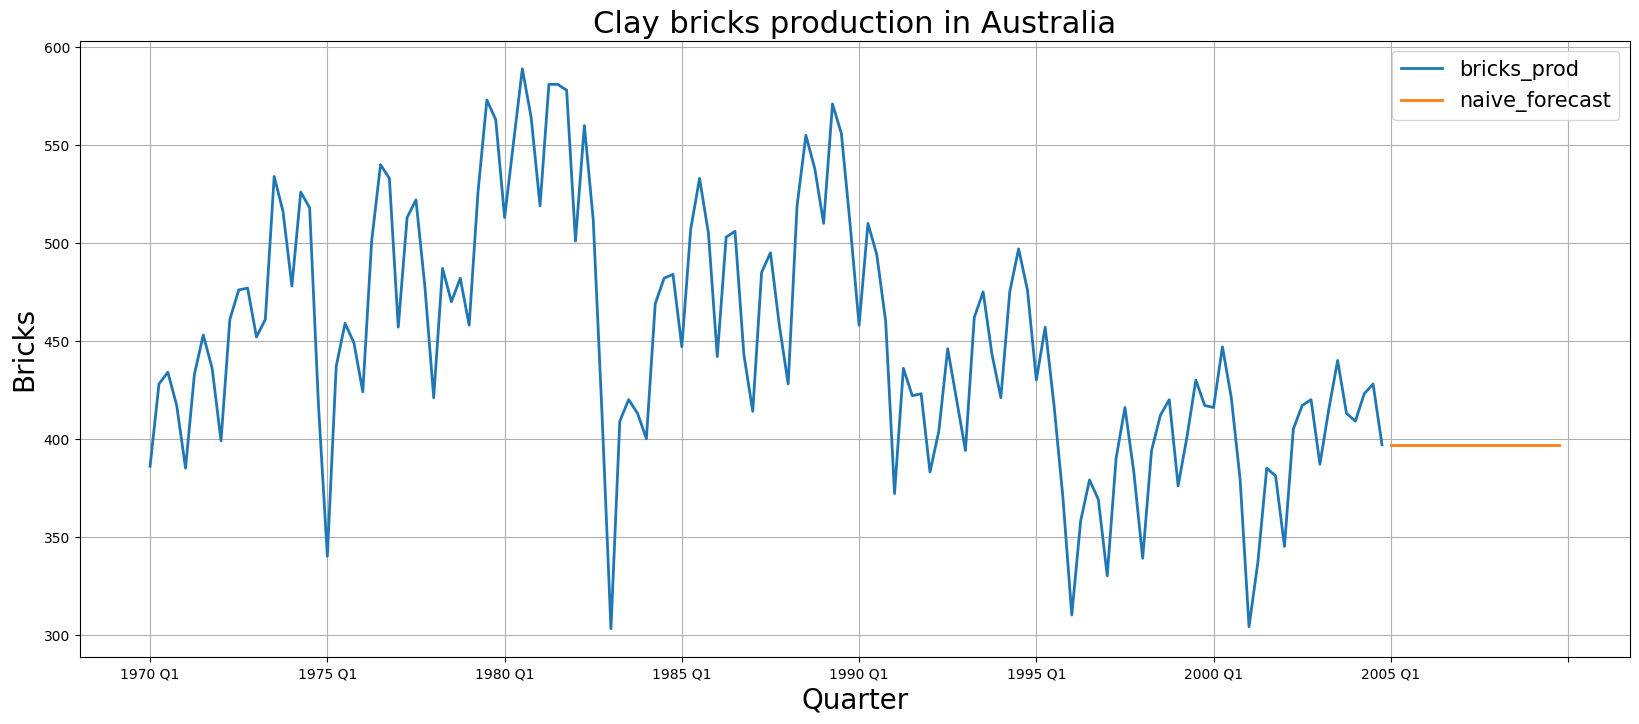

In [43]:
fig, ax = plt.subplots(1, 1, figsize = (20, 8))

# Concatenate the dataframe of predicted values with the dataframe of observed values:
plot_df = pd.concat([bricks, Y_pred_df]).set_index('ds')
plot_df[['bricks_prod', 'naive_forecast']].plot(ax=ax, linewidth=2)

# Specify graph features:
ax.set_title('Clay bricks production in Australia', fontsize=22)
ax.set_ylabel('Bricks', fontsize=20)
ax.set_xlabel('Quarter', fontsize=20)
ax.legend(prop={'size': 15})
ax.grid()

<p style="text-align: center;">
Figure 4: Naïve forecasts applied to clay brick production in Australia.
</p>

Because a naïve forecast is optimal when data follow a random walk, these are also called random walk forecasts and the random walk model can be used instead of `NAIVE`.

## Seasonal naïve method

A similar method is useful for highly seasonal data. In this case, we set each forecast to be equal to the last observed value from the same season (e.g., the same month of the previous year). Formally, the forecast for time  $T+h$ is written as

\begin{gather*}
\hat{y}_{T+h|T}=y_{T+h-m(k+1)}
\end{gather*}

where $m=$ the seasonal period, and $k$ is the integer part of  $(h−1)/m$ (i.e., the number of complete years in the forecast period prior to time $T+h)$. This looks more complicated than it really is. For example, with monthly data, the forecast for all future February values is equal to the last observed February value. With quarterly data, the forecast of all future Q2 values is equal to the last observed Q2 value (where Q2 means the second quarter). Similar rules apply for other months and quarters, and for other seasonal periods.

In [44]:
# SeasonalNaive's usage example:
from statsforecast.models import SeasonalNaive

# Define the model, fit and predict:
model = SeasonalNaive(season_length=4)
model = model.fit(y=y_bricks)
y_hat_dict = model.predict(h=20)

y_hat_dict

{'mean': array([409., 423., 428., 397., 409., 423., 428., 397., 409., 423., 428.,
        397., 409., 423., 428., 397., 409., 423., 428., 397.])}

In [45]:
# Create a column with the values predicted:
Y_pred_df["seasonal_naive_forecast"] = y_hat_dict["mean"]

The `lag()` function is optional here as `bricks` is quarterly data and so a seasonal naïve method will need a one-year lag. However, for some time series there is more than one seasonal period, and then the required lag must be specified.

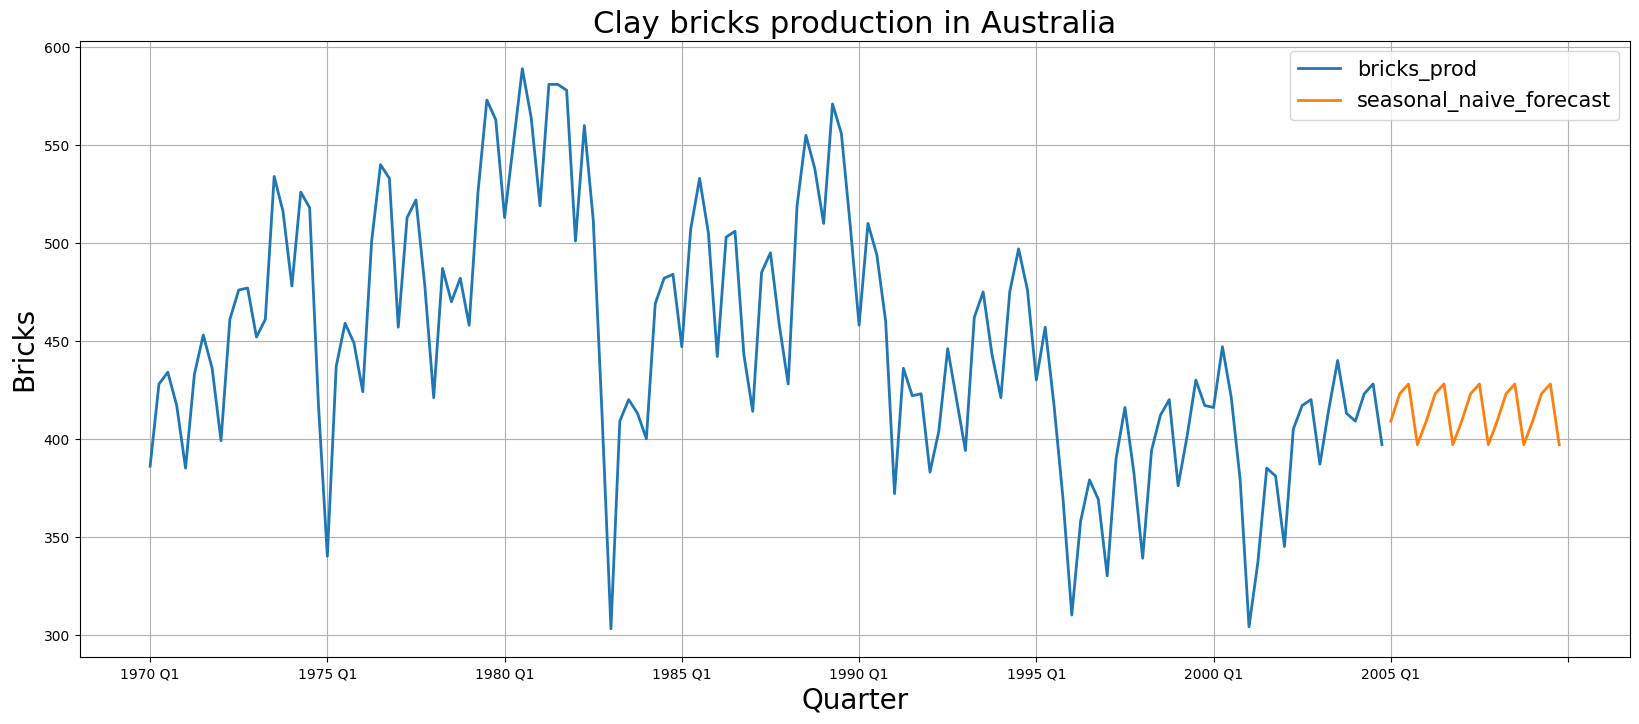

In [46]:
fig, ax = plt.subplots(1, 1, figsize = (20, 8))

# Concatenate the dataframe of predicted values with the dataframe of observed values:
plot_df = pd.concat([bricks, Y_pred_df]).set_index('ds')
plot_df[['bricks_prod', 'seasonal_naive_forecast']].plot(ax=ax, linewidth=2)

# Specify graph features:
ax.set_title('Clay bricks production in Australia', fontsize=22)
ax.set_ylabel('Bricks', fontsize=20)
ax.set_xlabel('Quarter', fontsize=20)
ax.legend(prop={'size': 15})
ax.grid()

<p style="text-align: center;">
Figure 5: Seasonal naïve forecasts applied to clay brick production in Australia.
</p>

## Drift method

A variation on the naïve method is to allow the forecasts to increase or decrease over time, where the amount of change over time (called the drift) is set to be the average change seen in the historical data. Thus the forecast for time $T+h$ is given by

\begin{gather*}
\hat{y}_{T+h|T}=y_{T}+\frac{h}{T-1}\sum_{t=2}^{T}(y_{t}-y_{t-1})=y_{T}+h\frac{y_{T}-y_{1}}{T-1}
\end{gather*}

This is equivalent to drawing a line between the first and last observations, and extrapolating it into the future.

In [47]:
# RandomWalkWithDrift's usage example:
from statsforecast.models import RandomWalkWithDrift

# Define the model, fit and predict:
model = RandomWalkWithDrift()
model = model.fit(y=y_bricks)
y_hat_dict = model.predict(h=20)

y_hat_dict

{'mean': array([397.07913669, 397.15827338, 397.23741007, 397.31654676,
        397.39568345, 397.47482014, 397.55395683, 397.63309353,
        397.71223022, 397.79136691, 397.8705036 , 397.94964029,
        398.02877698, 398.10791367, 398.18705036, 398.26618705,
        398.34532374, 398.42446043, 398.50359712, 398.58273381])}

In [48]:
# Create a column with the values predicted:
Y_pred_df["drift_forecast"] = y_hat_dict["mean"]

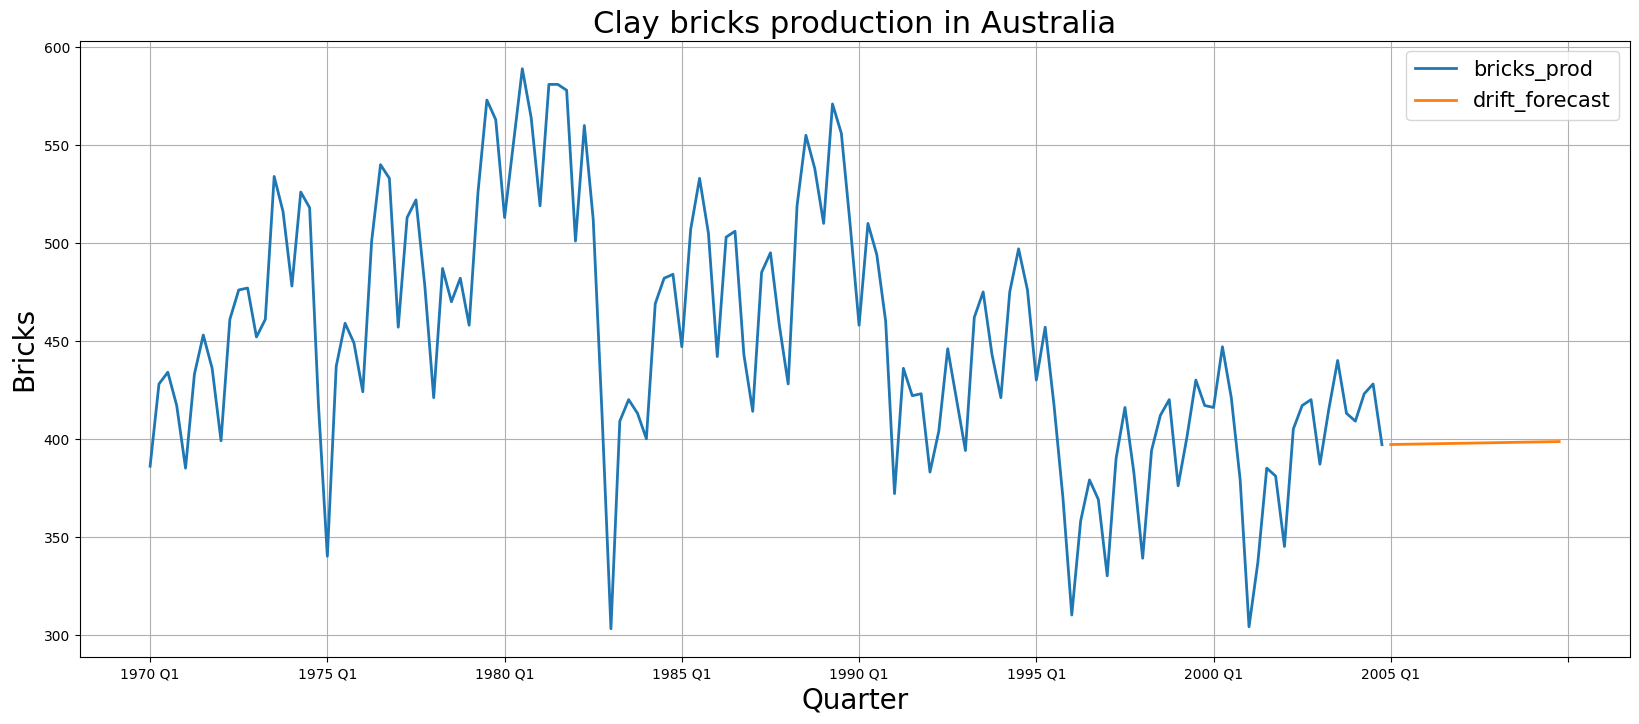

In [49]:
fig, ax = plt.subplots(1, 1, figsize = (20, 8))

# Concatenate the dataframe of predicted values with the dataframe of observed values:
plot_df = pd.concat([bricks, Y_pred_df]).set_index('ds')
plot_df[['bricks_prod', 'drift_forecast']].plot(ax=ax, linewidth=2)

# Specify graph features:
ax.set_title('Clay bricks production in Australia', fontsize=22)
ax.set_ylabel('Bricks', fontsize=20)
ax.set_xlabel('Quarter', fontsize=20)
ax.legend(prop={'size': 15})
ax.grid()

<p style="text-align: center;">
Figure 6: Drift forecasts applied to clay brick production in Australia.
</p>

## Example: Australian quarterly beer production

Figure 7 shows the first three methods applied to Australian quarterly beer production from 1992 to 2006, with the forecasts compared against actual values in the next 3.5 years.

In [50]:
# Create a dataframe:
beer = df[["Quarter","Beer"]]

#Inferior limit:
beer_mask=beer['Quarter']>="1992 Q1"
filtered_beer = beer[beer_mask]

#Superior limit:
beer_mask=filtered_beer['Quarter']<="2006 Q4"
beer = filtered_beer[beer_mask]
print(beer.head(2),"\n",beer.tail(2))

     Quarter  Beer
144  1992 Q1   443
145  1992 Q2   410 
      Quarter  Beer
202  2006 Q3   405
203  2006 Q4   491


In [51]:
# Create an array with the observed values:
y_beer = beer["Beer"].values

# Define column names:
beer.columns = ["ds","beer_prod"]

In [52]:
# Mean method:
model = HistoricAverage()
model = model.fit(y=y_beer)
mean = model.predict(h=14)

# Naive method:
model = Naive()
model = model.fit(y=y_beer)
naive = model.predict(h=14)

# Seasonal Naive method:
model = SeasonalNaive(season_length=4)
model = model.fit(y=y_beer)
snaive = model.predict(h=14)

print("Mean method:",mean,"\n\nNaive method:",naive,"\n\nSeasonal naïve method:",snaive)

Mean method: {'mean': array([436.45, 436.45, 436.45, 436.45, 436.45, 436.45, 436.45, 436.45,
       436.45, 436.45, 436.45, 436.45, 436.45, 436.45], dtype=float32)} 

Naive method: {'mean': array([491., 491., 491., 491., 491., 491., 491., 491., 491., 491., 491.,
       491., 491., 491.], dtype=float32)} 

Seasonal naïve method: {'mean': array([438., 386., 405., 491., 438., 386., 405., 491., 438., 386., 405.,
       491., 438., 386.], dtype=float32)}


In [53]:
# Specify the quarters predicted:
qua_pred = ['2007 Q1', '2007 Q2', '2006 Q1', '2006 Q2', '2006 Q3', '2006 Q4', '2007 Q1', '2007 Q2', '2007 Q3', '2007 Q4', '2008 Q1', '2008 Q2', '2009 Q2', '2010 Q2']

# Create a dataframe with the quarters and values predicted:
Y_pred_df = pd.DataFrame({'ds':qua_pred,
                        'mean_forecast':mean["mean"],
                        'naive_forecast':naive["mean"],
                        'snaive_forecast':snaive["mean"]})

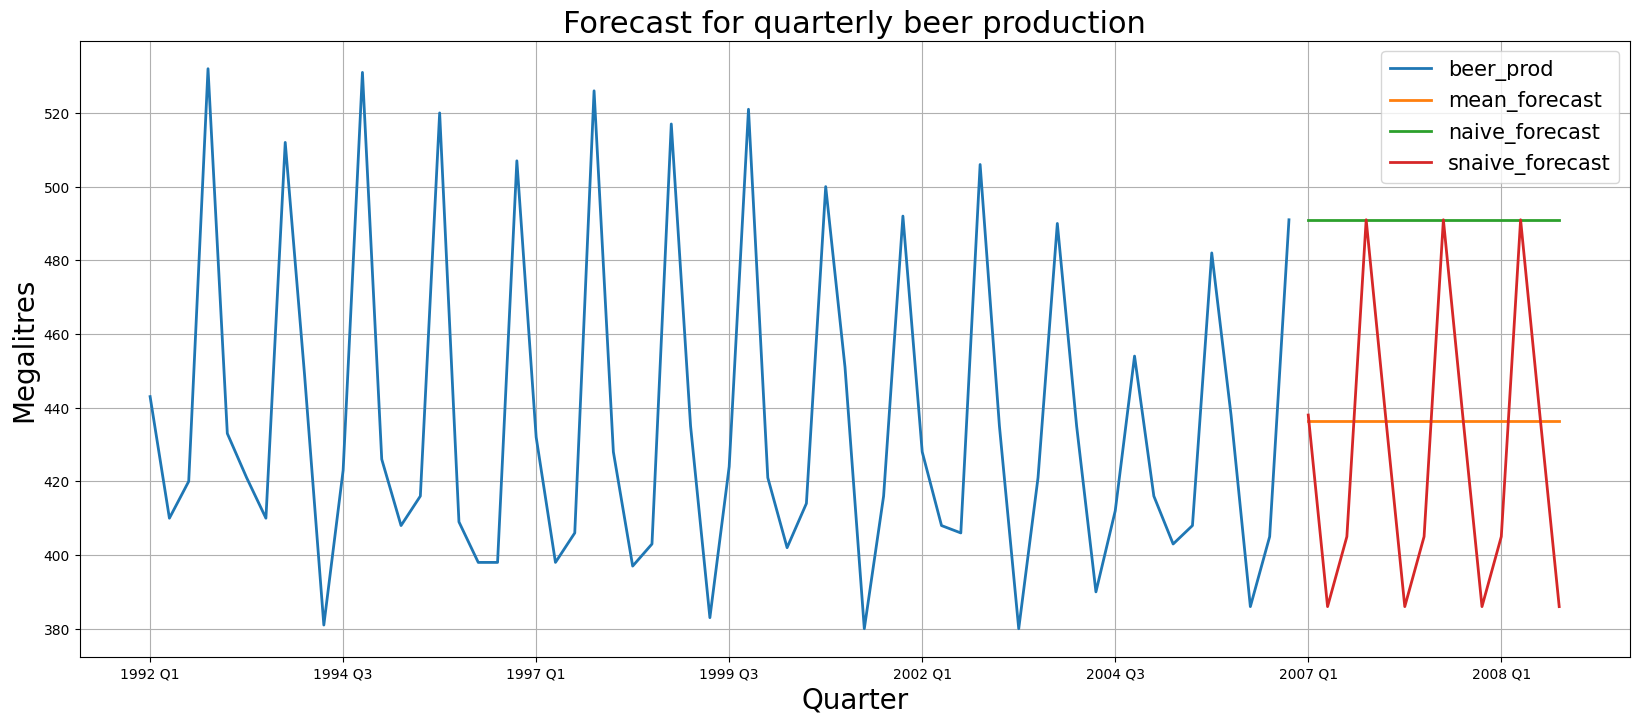

In [54]:
fig, ax = plt.subplots(1, 1, figsize = (20, 8))

# Concatenate the dataframe of predicted values with the dataframe of observed values:
plot_df = pd.concat([beer, Y_pred_df]).set_index('ds')
plot_df[['beer_prod', 'mean_forecast', 'naive_forecast', 'snaive_forecast']].plot(ax=ax, linewidth=2)

# Specify graph features:
ax.set_title('Forecast for quarterly beer production', fontsize=22)
ax.set_ylabel('Megalitres', fontsize=20)
ax.set_xlabel('Quarter', fontsize=20)
ax.legend(prop={'size': 15})
ax.grid()

<p style="text-align: center;">
Figure 7: Forecasts of Australian quarterly beer production.
</p>

In this case, only the seasonal naïve forecasts are close to the observed values from 2007 onwards.

## Example: Google’s daily closing stock price

In Figure 8, the non-seasonal methods are applied to Google’s daily closing stock price in 2015, and used to forecast one month ahead. Because stock prices are not observed every day, we first set up a new time index based on the trading days rather than calendar days.

In [55]:
# Create a dataframe from a csv file:
google_stock = pd.read_csv(my_path + "Assets/GOOGL.csv")

google_stock.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-01-02,26.629999,26.790001,26.393999,26.477501,26.477501,26480000
1,2015-01-05,26.357500,26.399500,25.887501,25.973000,25.973000,41182000
2,2015-01-06,26.025000,26.060499,25.277500,25.332001,25.332001,54456000
3,2015-01-07,25.547501,25.574499,25.182501,25.257500,25.257500,46918000
4,2015-01-08,25.075500,25.375000,24.750999,25.345501,25.345501,73054000


In [56]:
# Filter the year of interest:
google_mask = google_stock["Date"] <= "2015-12-31"
google_2015 = google_stock[google_mask]

google_2015.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-01-02,26.629999,26.790001,26.393999,26.477501,26.477501,26480000
1,2015-01-05,26.357500,26.399500,25.887501,25.973000,25.973000,41182000
2,2015-01-06,26.025000,26.060499,25.277500,25.332001,25.332001,54456000
3,2015-01-07,25.547501,25.574499,25.182501,25.257500,25.257500,46918000
4,2015-01-08,25.075500,25.375000,24.750999,25.345501,25.345501,73054000


In [57]:
# Filter the year of interest:
google_mask = google_stock["Date"] > "2015-12-31"
google_2016 = google_stock[google_mask]

google_2016.head()

,Date,Open,High,Low,Close,Adj Close,Volume
252,2016-01-04,38.110001,38.110001,37.376999,37.972000,37.972000,67382000
253,2016-01-05,38.205002,38.459999,37.782501,38.076500,38.076500,45216000
254,2016-01-06,37.518501,38.286499,37.400002,37.966499,37.966499,48206000
255,2016-01-07,37.324501,37.765499,36.764000,37.049999,37.049999,63132000
256,2016-01-08,37.389999,37.506001,36.445999,36.545502,36.545502,47506000


In [58]:
# Create arrays with Close values:
y_google_2015 = google_2015["Close"].values
y_google_2016 = google_2016["Close"].values

In [59]:
# Mean method:
model = HistoricAverage()
model = model.fit(y=y_google_2015)
mean = model.predict(h=len(y_google_2016))

# Naive method:
model = Naive()
model = model.fit(y=y_google_2015)
naive = model.predict(h=len(y_google_2016))

# Drift method:
model = RandomWalkWithDrift()
model = model.fit(y=y_google_2015)
drift = model.predict(h=len(y_google_2016))

print("Mean method:",mean,"\n\nNaive method:",naive,"\n\nDrift method:",drift)

Mean method: {'mean': array([30.99941083, 30.99941083, 30.99941083, 30.99941083, 30.99941083,
       30.99941083, 30.99941083, 30.99941083, 30.99941083, 30.99941083,
       30.99941083, 30.99941083, 30.99941083, 30.99941083, 30.99941083,
       30.99941083, 30.99941083, 30.99941083])} 

Naive method: {'mean': array([38.900501, 38.900501, 38.900501, 38.900501, 38.900501, 38.900501,
       38.900501, 38.900501, 38.900501, 38.900501, 38.900501, 38.900501,
       38.900501, 38.900501, 38.900501, 38.900501, 38.900501, 38.900501])} 

Drift method: {'mean': array([38.94999502, 38.99948905, 39.04898307, 39.0984771 , 39.14797112,
       39.19746514, 39.24695917, 39.29645319, 39.34594722, 39.39544124,
       39.44493526, 39.49442929, 39.54392331, 39.59341733, 39.64291136,
       39.69240538, 39.74189941, 39.79139343])}


In [60]:
# Specify the quarters predicted:
date_pred = google_2016["Date"]

# Create a dataframe with the quarters and values predicted:
Y_pred_df = pd.DataFrame({'Date':date_pred,
                        'mean_forecast':mean["mean"],
                        'naive_forecast':naive["mean"],
                        'drift_forecast':drift["mean"]})

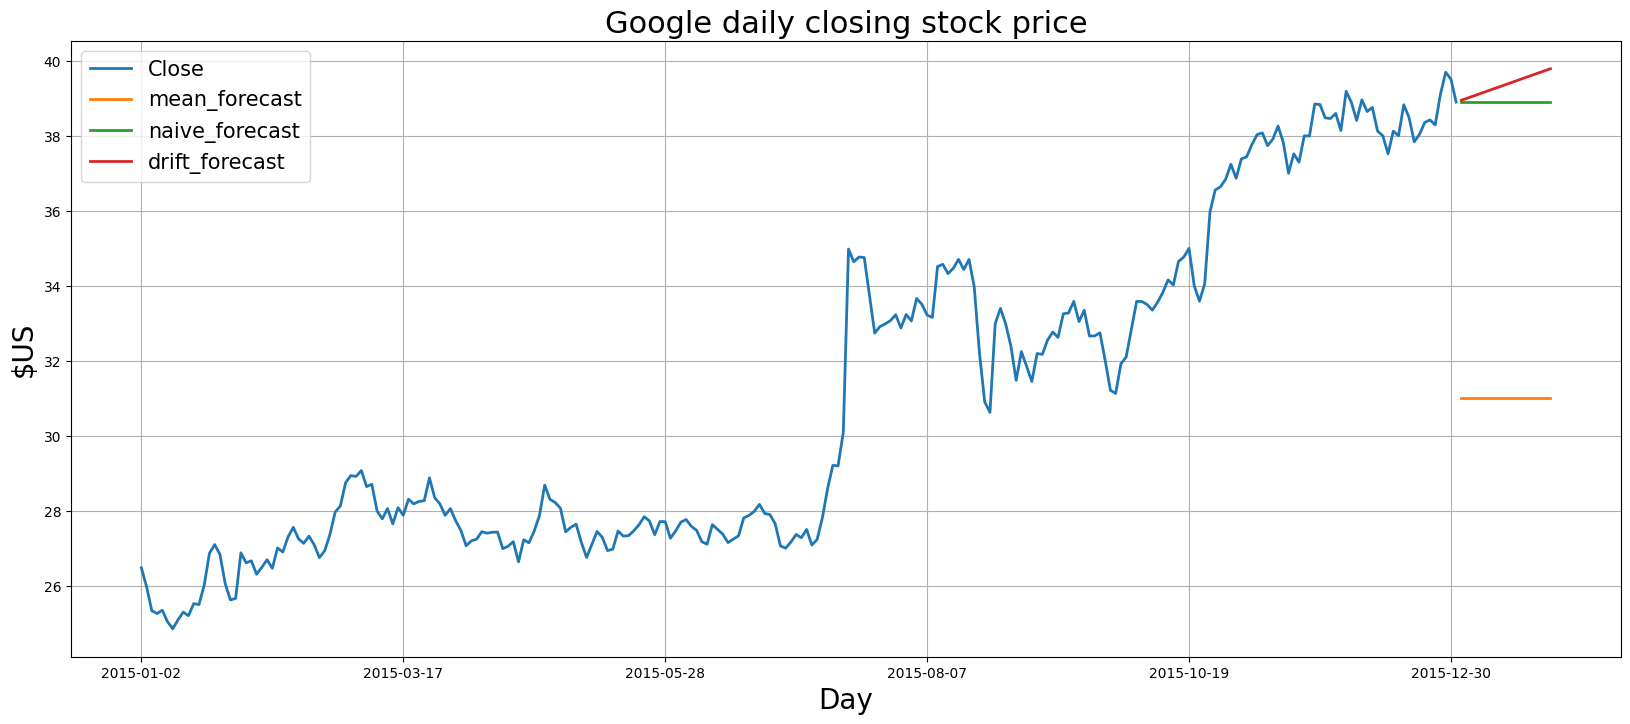

In [61]:
fig, ax = plt.subplots(1, 1, figsize = (20, 8))

# Concatenate the dataframe of predicted values with the dataframe of observed values:
plot_df = pd.concat([google_2015, Y_pred_df]).set_index('Date')
plot_df[['Close', 'mean_forecast', 'naive_forecast', 'drift_forecast']].plot(ax=ax, linewidth=2)

# Specify graph features:
ax.set_title('Google daily closing stock price', fontsize=22)
ax.set_ylabel('$US', fontsize=20)
ax.set_xlabel('Day', fontsize=20)
ax.legend(prop={'size': 15})
ax.grid()

<p style="text-align: center;">
Figure 8: Forecasts based on Google’s daily closing stock price in 2015.
</p>

Sometimes one of these simple methods will be the best forecasting method available; but in many cases, these methods will serve as benchmarks rather than the method of choice. That is, any forecasting methods we develop will be compared to these simple methods to ensure that the new method is better than these simple alternatives. If not, the new method is not worth considering.